In [1]:
import os
import matplotlib.pyplot as plt
import glob
import pickle
from keras.utils import to_categorical

from pkl_reader import *
from lstm_impl import CombinedLSTM
from kf_impl import EKF_CV_MODEL

Using TensorFlow backend.


In [2]:
# The function to extract training data from snippets pickles
def extract_data(pklfile, full_traj=False, crop_traj=True):
    with open(pklfile, 'rb') as f:
        dataset_all = pickle.load(f)
        
    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    if crop_traj:
        history_traj_data = np.array(dataset_all['features'])[:, :, :3]
    else:
        history_traj_data = np.array(dataset_all['features'])

    # All the future trajectoreis (x, y), with shape (batch_size, sequence_length, feature_dims)
    if crop_traj:
        future_traj_data = np.array(dataset_all['labels'])[:, :, :2]
    else:
        future_traj_data = np.array(dataset_all['labels'])

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if full_traj:
        traj_idx = np.array(dataset_all['traj_idx'])
        return history_traj_data, future_traj_data, goals_position, one_hot_goal, traj_idx
    else:  
        return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

test_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}
test_set_kf  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

test_set['history_traj_data'], test_set['future_traj_data'], test_set['goal_position'], test_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True)
test_set_kf['history_traj_data'], test_set_kf['future_traj_data'], test_set_kf['goal_position'], test_set_kf['one_hot_goal'], traj_idx_kf = extract_data(pklfile, full_traj=True, crop_traj=False)

Found 6 pkl files: ['./dataset/pilot_dataset_12_08_13_02_29.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_0.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_1.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_2.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_3.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_4.pkl']


In [4]:
# Build the model
history_shape = test_set['history_traj_data'].shape
goals_position_shape = test_set['goal_position'].shape
one_hot_goal_shape = test_set['one_hot_goal'].shape
future_shape = test_set['future_traj_data'].shape
hidden_dim = 100
beta = 0.
gamma = 10.
comb_lstm = CombinedLSTM(history_shape, goals_position_shape, one_hot_goal_shape, future_shape, hidden_dim, beta, gamma)
# comb_lstm.load('file_name')
# comb_lstm.goal_model.load()
# comb_lstm.traj_model.load()

Train on 1763 samples, validate on 1763 samples
Epoch 1/100
1763/1763 [==============================] - 1s 568us/step - loss: 5.9664 - top_k_acc: 0.0278 - val_loss: 5.7429 - val_top_k_acc: 0.0216
Epoch 2/100
1763/1763 [==============================] - 0s 221us/step - loss: 4.5788 - top_k_acc: 0.1044 - val_loss: 0.5778 - val_top_k_acc: 0.1656
Epoch 3/100
1763/1763 [==============================] - 0s 218us/step - loss: 0.1752 - top_k_acc: 0.1741 - val_loss: 1.8818e-07 - val_top_k_acc: 0.1849
Epoch 4/100
1763/1763 [==============================] - 0s 229us/step - loss: 8.5044e-08 - top_k_acc: 0.1866 - val_loss: 6.5500e-08 - val_top_k_acc: 0.1872
Epoch 5/100
1763/1763 [==============================] - 0s 223us/step - loss: 6.5287e-08 - top_k_acc: 0.1872 - val_loss: 6.5233e-08 - val_top_k_acc: 0.1872
Epoch 6/100
1763/1763 [==============================] - 0s 218us/step - loss: 6.5220e-08 - top_k_acc: 0.1872 - val_loss: 6.5167e-08 - val_top_k_acc: 0.1872
Epoch 7/100
1763/1763 [=======

Epoch 53/100
1763/1763 [==============================] - 0s 213us/step - loss: 5.5185e-08 - top_k_acc: 0.1877 - val_loss: 5.5002e-08 - val_top_k_acc: 0.1877
Epoch 54/100
1763/1763 [==============================] - 0s 212us/step - loss: 5.4884e-08 - top_k_acc: 0.1877 - val_loss: 5.4720e-08 - val_top_k_acc: 0.1877
Epoch 55/100
1763/1763 [==============================] - 0s 211us/step - loss: 5.4572e-08 - top_k_acc: 0.1877 - val_loss: 5.4356e-08 - val_top_k_acc: 0.1877
Epoch 56/100
1763/1763 [==============================] - 0s 213us/step - loss: 5.4250e-08 - top_k_acc: 0.1877 - val_loss: 5.4078e-08 - val_top_k_acc: 0.1877
Epoch 57/100
1763/1763 [==============================] - 0s 217us/step - loss: 5.3939e-08 - top_k_acc: 0.1877 - val_loss: 5.3676e-08 - val_top_k_acc: 0.1877
Epoch 58/100
1763/1763 [==============================] - 0s 212us/step - loss: 5.3599e-08 - top_k_acc: 0.1877 - val_loss: 5.3359e-08 - val_top_k_acc: 0.1877
Epoch 59/100
1763/1763 [============================

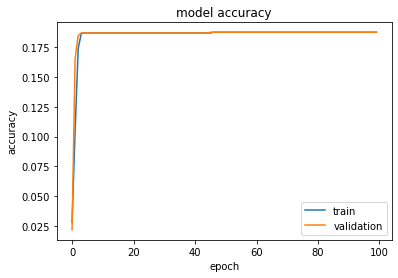

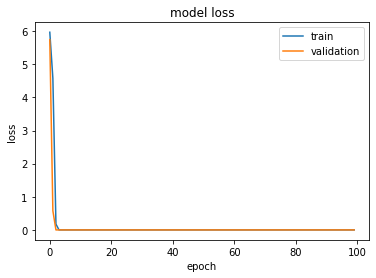

Train on 1763 samples, validate on 1763 samples
Epoch 1/100
1763/1763 [==============================] - 2s 1ms/step - loss: 1.5460 - accuracy: 0.7934 - val_loss: 0.5288 - val_accuracy: 0.9352
Epoch 2/100
1763/1763 [==============================] - 1s 767us/step - loss: 0.4687 - accuracy: 0.9424 - val_loss: 0.4458 - val_accuracy: 0.9515
Epoch 3/100
1763/1763 [==============================] - 1s 768us/step - loss: 0.4162 - accuracy: 0.9504 - val_loss: 0.3758 - val_accuracy: 0.9499
Epoch 4/100
1763/1763 [==============================] - 1s 773us/step - loss: 0.4075 - accuracy: 0.9497 - val_loss: 0.3720 - val_accuracy: 0.9490
Epoch 5/100
1763/1763 [==============================] - 1s 778us/step - loss: 0.4016 - accuracy: 0.9499 - val_loss: 0.4694 - val_accuracy: 0.9428
Epoch 6/100
1763/1763 [==============================] - 1s 778us/step - loss: 0.4394 - accuracy: 0.9466 - val_loss: 0.3763 - val_accuracy: 0.9507
Epoch 7/100
1763/1763 [==============================] - 1s 793us/step -

1763/1763 [==============================] - 1s 809us/step - loss: 0.1852 - accuracy: 0.9444 - val_loss: 0.1792 - val_accuracy: 0.9537
Epoch 57/100
1763/1763 [==============================] - 1s 833us/step - loss: 0.1825 - accuracy: 0.9475 - val_loss: 0.1854 - val_accuracy: 0.9502
Epoch 58/100
1763/1763 [==============================] - 1s 792us/step - loss: 0.1801 - accuracy: 0.9468 - val_loss: 0.1808 - val_accuracy: 0.9477
Epoch 59/100
1763/1763 [==============================] - 1s 793us/step - loss: 0.1879 - accuracy: 0.9450 - val_loss: 0.1778 - val_accuracy: 0.9279
Epoch 60/100
1763/1763 [==============================] - 1s 785us/step - loss: 0.1782 - accuracy: 0.9450 - val_loss: 0.1658 - val_accuracy: 0.9543
Epoch 61/100
1763/1763 [==============================] - 1s 803us/step - loss: 0.1774 - accuracy: 0.9484 - val_loss: 0.2136 - val_accuracy: 0.9539
Epoch 62/100
1763/1763 [==============================] - 1s 798us/step - loss: 0.2138 - accuracy: 0.9395 - val_loss: 0.1819 

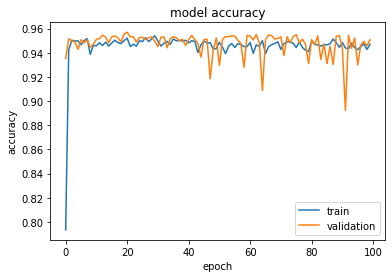

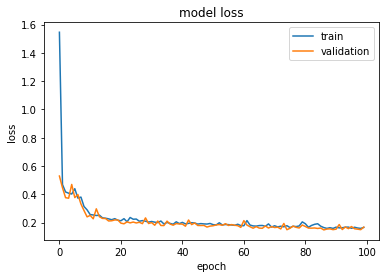

In [5]:
comb_lstm.fit(test_set, test_set,verbose=1)

In [ ]:
comb_lstm.save('test')

In [ ]:
# Load the model
models_on_disk = glob.glob('./model/*.h5')
models_on_disk.sort()
print('Found %d model files: %s' % (len(models_on_disk), models_on_disk))

In [ ]:
comb_lstm.load('./model/LSTM_h100_b1.000_fold0')
#comb_lstm.load('./model/test')

In [6]:
top_k_goal = [0, 1, 2]
goal_pred, traj_pred_dict = comb_lstm.predict(test_set, top_k_goal=top_k_goal)
print(traj_pred_dict[0].shape)

(1763, 20, 2)


In [ ]:
kf = EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)

In [ ]:
kf.load('./model/EKF_CV_fold0.pkl')
goal_pred, traj_pred_dict = kf.predict(test_set_kf)

In [7]:
# for i in range(len(traj_idx) - 1)

# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_set['goal_position'].reshape((test_set['goal_position'].shape[0], 32, 3))
test_hist_traj    = test_set['history_traj_data']
test_future_traj  = test_set['future_traj_data']
test_one_hot_goal = test_set['one_hot_goal']

for num_traj in range(2):
    
    print("Start processing trajectory # %03d ....." % num_traj)
    start_idx = traj_idx[num_traj]
    end_idx   = traj_idx[num_traj+1]
    directory = './figures/%03d' % num_traj
    if not os.path.exists(directory):
        os.mkdir(directory)

    for i in range(start_idx, end_idx):

        fig = plt.figure(dpi=200)
        plt.suptitle('LSTM', va='center')
        plt.subplot(211)

        vector = test_goals_coords[i][-3,:2] - test_goals_coords[i][-1,:2]
        th = np.arctan2(vector[1], vector[0])
        R = np.array([[ np.cos(th), np.sin(th)], \
                      [-np.sin(th), np.cos(th)]])

        # Plot the vehicle trajectory in the snippet
        test_hist_traj_rot = test_hist_traj[i][:,:2] @ R.T
        test_future_traj_rot = test_future_traj[i][:,:2] @ R.T
        plt.plot(test_hist_traj_rot[:,0], test_hist_traj_rot[:,1], 'k')
        plt.plot(test_future_traj_rot[:,0], test_future_traj_rot[:,1], color = '#1f77b4')
        
        probs = goal_pred[i].copy()
        prob_undetermined = probs[-1]
        probs.sort()
        for top_k, traj_pred in traj_pred_dict.items():
            traj_pred_rot      = traj_pred[i][:, :2] @ R.T
            prob = probs[-1-top_k]
            plt.plot(traj_pred_rot[:,0], traj_pred_rot[:,1], '.', markersize = 3, color = '#ff770e', alpha= prob)

        # Plot the occupancy in the snippet
        test_goals_coords_rot = test_goals_coords[i][:,:2] @ R.T
        for goal, occup in zip(test_goals_coords_rot, test_goals_coords[i]):
            if occup[2] > 0:
                plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
            else:
                plt.plot(goal[0], goal[1], 'ko', markersize = 9)

        # Get the ground truth intention
        gt_idx = np.argmax(test_one_hot_goal[i])
        # Predictions above a threshold
        thres = 1e-2
        
        best_k_idx = [np.argsort(goal_pred[i])[-1-k] for k in top_k_goal]
#         best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
#         print(np.max(goal_pred[i]))
        if gt_idx == 32: # If it is "-1" -> undetermined 
            plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
        else:
            plt.plot(test_goals_coords_rot[gt_idx][0], test_goals_coords_rot[gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)

        for j in best_k_idx:
            if j == 32:
                plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9, alpha=prob_undetermined)
            else:
                plt.plot(test_goals_coords_rot[j][0], test_goals_coords_rot[j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)

        plt.title('Trajectory and Spots in Ego Frame')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
    #     plt.axis('equal')

        plt.subplot(212)
        p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
        p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
        plt.xlabel('Goal Index')
        plt.ylabel('Probability')
        plt.title('Likelihood of Selecting Different Goals')
        plt.legend()
        plt.tight_layout()
        
        
        fig.savefig('./figures/%03d/frame_%03d.png' % (num_traj, i-start_idx))
        plt.close(fig)
        
    fps = 2
    mv = os.system("ffmpeg -r {0:d} -i ./figures/{1:03d}/frame_%03d.png -vcodec mpeg4 -y ./figures/{1:03d}_movie.mp4".format(fps, num_traj) )
    if mv == 0:
        print("Trajectory # %03d movie saved successfully." % num_traj)
    else:
        print("Meet problem saving Trajectory # %03d movie." % num_traj)

Start processing trajectory # 000 .....
Trajectory # 000 movie saved successfully.
Start processing trajectory # 001 .....
Trajectory # 001 movie saved successfully.
